TwoMoons Diagnostics

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# ensure the backend is set
import os
if "KERAS_BACKEND" not in os.environ:
    # set this to "torch", "tensorflow", or "jax"
    os.environ["KERAS_BACKEND"] = "jax"

import keras

# for BayesFlow devs: this ensures that the latest dev version can be found
import sys
sys.path.append('../')

import bayesflow as bf
from bayesflow.diagnostics.plot_losses import plot_losses
from bayesflow.diagnostics.plot_recovery import plot_recovery

In [3]:
def alpha_prior():
    alpha = np.random.uniform(-np.pi / 2, np.pi / 2)
    return dict(alpha=alpha)

def r_prior():
    r = np.random.normal(0.1, 0.01)
    return dict(r=r)

def theta_prior():
    theta = np.random.uniform(-1, 1, 2)
    return dict(theta=theta)

def forward_model(theta, alpha, r):
    x1 = -np.abs(theta[0] + theta[1]) / np.sqrt(2) + r * np.cos(alpha) + 0.25
    x2 = (-theta[0] + theta[1]) / np.sqrt(2) + r * np.sin(alpha)
    return dict(x=np.array([x1, x2]))

In [6]:
simulator = bf.simulators.CompositeLambdaSimulator([alpha_prior, r_prior, theta_prior, forward_model])

In [7]:
# generate 128 random draws from the joint distribution p(r, alpha, theta, x)
sample_data = simulator.sample((128,))

In [8]:
print("Type of sample_data:\n\t", type(sample_data))
print("Keys of sample_data:\n\t", sample_data.keys())
print("Types of sample_data values:\n\t", {k: type(v) for k, v in sample_data.items()})
print("Shapes of sample_data values:\n\t", {k: v.shape for k, v in sample_data.items()})

Type of sample_data:
	 <class 'dict'>
Keys of sample_data:
	 dict_keys(['alpha', 'r', 'theta', 'x'])
Types of sample_data values:
	 {'alpha': <class 'numpy.ndarray'>, 'r': <class 'numpy.ndarray'>, 'theta': <class 'numpy.ndarray'>, 'x': <class 'numpy.ndarray'>}
Shapes of sample_data values:
	 {'alpha': (128, 1), 'r': (128, 1), 'theta': (128, 2), 'x': (128, 2)}


In [9]:
sample_data

{'alpha': array([[ 0.811846  ],
        [ 1.1655375 ],
        [ 0.690349  ],
        [-1.3843633 ],
        [-0.9577933 ],
        [-1.2079015 ],
        [ 1.5107541 ],
        [ 0.96131116],
        [ 0.09636723],
        [ 0.02404731],
        [-0.9631397 ],
        [-1.5443141 ],
        [ 0.3322162 ],
        [-0.8289226 ],
        [ 1.545839  ],
        [ 1.3099878 ],
        [-1.1293337 ],
        [-1.1112677 ],
        [-1.2859131 ],
        [-0.00848705],
        [-0.826562  ],
        [-0.05401359],
        [-0.5733626 ],
        [ 1.441103  ],
        [ 1.3535103 ],
        [ 0.82197374],
        [ 1.1405069 ],
        [ 1.5078775 ],
        [-0.24578635],
        [-1.2971845 ],
        [ 1.2200094 ],
        [ 1.2412809 ],
        [ 0.8568348 ],
        [-0.14014174],
        [ 1.2381922 ],
        [-0.00458808],
        [-0.29915315],
        [-0.014065  ],
        [-0.36981848],
        [ 0.08939534],
        [-1.298005  ],
        [ 0.08107368],
        [ 1.1527332 ],
  

In [10]:
# data_adapter = configurator
data_adapter = bf.ContinuousApproximator.build_data_adapter(
    inference_variables=["theta"],
    inference_conditions=["x"],
)

In [11]:
num_training_batches = 1024
num_validation_batches = 256
batch_size = 128

In [12]:
training_samples = simulator.sample((num_training_batches * batch_size,))
validation_samples = simulator.sample((num_validation_batches * batch_size,))

In [13]:
training_dataset = bf.datasets.OfflineDataset(training_samples, batch_size=batch_size, data_adapter=data_adapter)
validation_dataset = bf.datasets.OfflineDataset(validation_samples, batch_size=batch_size, data_adapter=data_adapter)

In [14]:
inference_network = bf.networks.FlowMatching(
    subnet="mlp",
    subnet_kwargs=dict(
        depth=6,
        width=256,
    ),
)

In [15]:
# Approximator is equivalent to Amortizer
approximator = bf.ContinuousApproximator(
    inference_network=inference_network,
    data_adapter=data_adapter,
)

In [16]:
learning_rate = 1e-4
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

In [36]:
class BatchLossHistory(keras.callbacks.Callback):
    def __init__(self):
        super().__init__()
        self.training_loss = []
        self.validation_loss = []

    def on_train_batch_end(self, batch, logs=None):
        # 'logs' is a dictionary containing loss and other metrics
        training_loss = logs.get('loss')
        self.training_loss.append(training_loss)
        
    def on_test_batch_end(self, batch, logs=None):
        validation_loss = logs.get('loss')
        self.validation_loss.append(validation_loss)

In [37]:
approximator.compile(optimizer=optimizer)

In [38]:
batch_loss_history = BatchLossHistory()

In [39]:
history = approximator.fit(
    epochs=10,
    dataset=training_dataset,
    validation_data=validation_dataset,
    callbacks=[batch_loss_history]
)

INFO:bayesflow:Fitting on dataset instance of OfflineDataset.


Epoch 1/10
1024/1024 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - loss: 0.5526 - loss/inference_loss: 0.5526 - val_loss: 0.5321 - val_loss/inference_loss: 0.5321
Epoch 2/10
1024/1024 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - loss: 0.5567 - loss/inference_loss: 0.5567 - val_loss: 0.7145 - val_loss/inference_loss: 0.7145
Epoch 3/10
1024/1024 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - loss: 0.5549 - loss/inference_loss: 0.5549 - val_loss: 0.5232 - val_loss/inference_loss: 0.5232
Epoch 4/10
1024/1024 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - loss: 0.5476 - loss/inference_loss: 0.5476 - val_loss: 0.4488 - val_loss/inference_loss: 0.4488
Epoch 5/10
1024/1024 ━━━━━━━━━━━━━━━━━━━━ 16s 15ms/step - loss: 0.5523 - loss/inference_loss: 0.5523 - val_loss: 0.4283 - val_loss/inference_loss: 0.4283
Epoch 6/10
1024/1024 ━━━━━━━━━━━━━━━━━━━━ 16s 15ms/step - loss: 0.5580 - loss/inference_loss: 0.5580 - val_loss: 0.6679 - val_loss/inference_loss: 0.6679
Epoch 7/10
1024/1024 ━━━━━━━━━━━━━━━━━━━━ 16s 15ms/step - loss: 0.5506 - los

In [40]:
type(batch_loss_history.validation_loss)

list

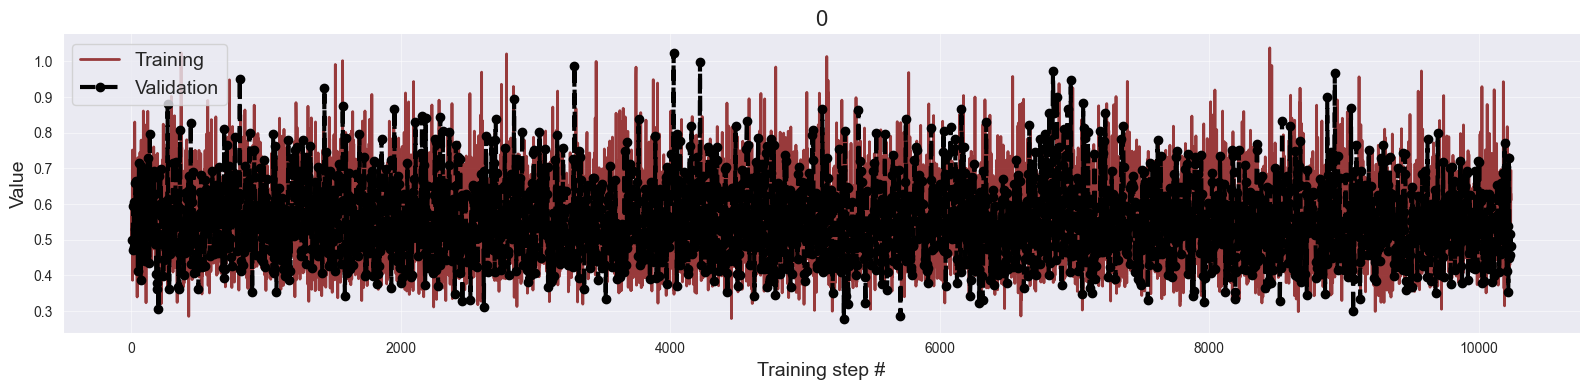

In [42]:
import pandas as pd

f = plot_losses(
    train_losses=pd.DataFrame(batch_loss_history.training_loss), 
    val_losses=pd.DataFrame(batch_loss_history.validation_loss), 
    moving_average=True
)

# Validation

In [55]:
# Set the number of posterior draws you want to get
num_samples = 500

# Obtain samples from amortized posterior
conditions = {"x": np.array([[0.0, 0.0]]).astype("float32")}
samples_at_origin = approximator.sample(conditions=conditions, num_samples=num_samples)

In [56]:
samples_at_origin

{'theta': array([[[ 0.17654721,  0.27041006],
         [ 0.12645097,  0.24587561],
         [-0.19934806, -0.278135  ],
         [-0.24838944, -0.24566503],
         [-0.23984583, -0.25675145],
         [ 0.15274203,  0.27565002],
         [-0.17649002, -0.28321353],
         [ 0.2847274 ,  0.16072123],
         [ 0.26681536,  0.14605851],
         [ 0.17062895,  0.26429826],
         [-0.28589755, -0.17278582],
         [-0.18308169, -0.29656368],
         [ 0.23003347,  0.24603625],
         [ 0.24050273,  0.21084891],
         [ 0.26269466,  0.12824804],
         [ 0.1484585 ,  0.26595044],
         [ 0.26594985,  0.2410507 ],
         [ 0.25229037,  0.24877094],
         [-0.21716174, -0.25466734],
         [ 0.22001   ,  0.258107  ],
         [-0.26463276, -0.12307405],
         [ 0.25718766,  0.23288907],
         [-0.23486198, -0.09413613],
         [ 0.27260107,  0.22248606],
         [-0.24408428, -0.2348922 ],
         [ 0.28494632,  0.16640714],
         [-0.23431693, -0.249

In [42]:
sample_data["theta"].shape

(128, 2)

In [50]:
np.reshape(samples_at_origin, (128, 2, 1)).shape

(128, 2, 1)

TypeError: unsupported operand type(s) for -: 'NoneType' and 'int'

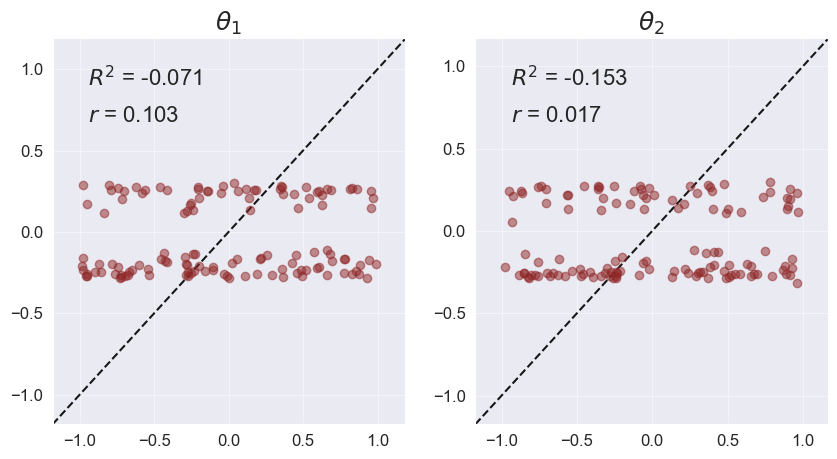

In [53]:
f = plot_recovery(post_samples=np.swapaxes(samples_at_origin, 0, 1), prior_samples=np.array(sample_data['theta']))